In [18]:
using IndexedGraphs, SparseArrays, MatrixProductBP
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

In [169]:
mutable struct Ising2D{T<:Real}  <: BPFactor 
    βJv :: T
    βJh :: T
    βh :: T
    border :: Bool
end

spin(x, i = 0) = 3-2x

function (f::Ising2D)(xᵢᵗ⁺¹::Integer,xₙᵢᵗ::AbstractVector{<:Integer}, xᵢᵗ::Integer)
    h = f.βh * spin(xᵢᵗ)
    h += spin(xᵢᵗ)*(f.βJv*spin(xᵢᵗ⁺¹) + 0.5*f.βJh*sum(spin, xₙᵢᵗ))
    exp(h)
end

In [170]:
openchain(n)=spdiagm(-1=>fill(true,n-1),1=>fill(true,n-1))
periodicchain(n)=(x=openchain(n); x[n,1]=x[1,n]=true; x)

periodicchain (generic function with 1 method)

Start with small but not that small external field to help convergence

In [223]:
βJ = 0.5
βh = 1e-3
N = 3
T = 100
G = IndexedBiDiGraph(periodicchain(N))

w = [[Ising2D(βJ, βJ, βh, i == N || i == 1) for t=0:T] for i=1:N]
bp = mpbp(G, w, fill(2,N), T);

In [224]:
spin(x, i = 0) = 3-2x
cb = CB_BP(bp; f=spin);

In [225]:
svd_trunc = TruncBondThresh(6, 1e-6)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.2);

Running MPBP: iter 14 	 Time: 0:00:27
  Δ:                  0.0007508491930466876
  SVD tolerance, m':  1.0e-6, 6

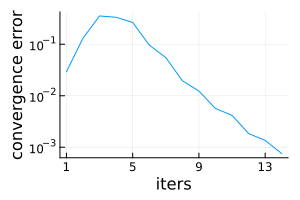

In [226]:
using Plots
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [227]:
m_bp = means(spin, bp)
m_bp[N÷2][T÷2], (1 - sinh(2βJ)^(-4))^(1/8)
# m_bp[N÷2][T÷2], sinh(βh)/sqrt(sinh(βh)^2+exp(-4βJ))

(0.9120954566900291, 0.911319377877496)

Now reduce external field to almost zero

In [228]:
for i in eachindex(w)
    for t in eachindex(w[i])
        w[i][t].βh = 1e-6
    end
end

In [229]:
svd_trunc = TruncBondThresh(8, 1e-6)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-3, damp=0.2);

Running MPBP: iter 17 	 Time: 0:00:41
  Δ:                  0.0008066392142779266
  SVD tolerance, m':  1.0e-6, 8

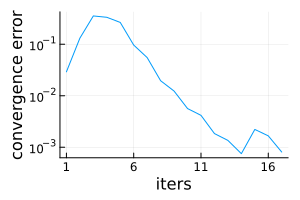

In [230]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [231]:
m_bp = means(spin, bp)
m_bp[N÷2][T÷2], (1 - sinh(2βJ)^(-4))^(1/8)

(0.9113633319794392, 0.911319377877496)

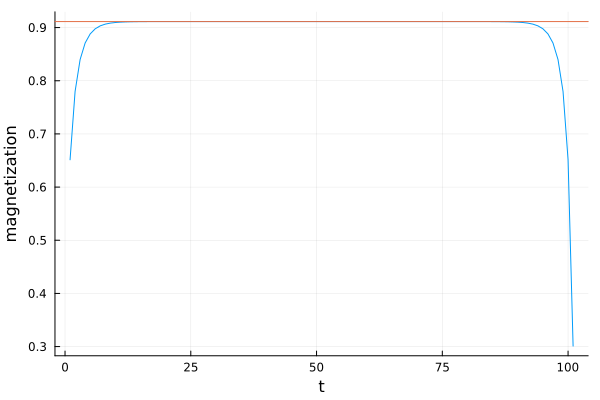

In [232]:
plot(m_bp[N÷2], label="", xlabel="t", ylabel="magnetization")
hline!([(1 - sinh(2βJ)^(-4))^(1/8)], label="")

In [233]:
F = bethe_free_energy(bp) / (N*(T+1))

-1.0201651461428574

## Infinite graph

In [234]:
# βJ = 0.5
# βh = 0.001
# T = 50

wᵢ = fill(Ising2D(βJ, βJ, βh, false), T+1)
bp_inf = mpbp_infinite_graph(2, wᵢ, 2);

In [235]:
cb_inf = CB_BP(bp_inf; f=spin);

Running MPBP: iter 21 	 Time: 0:02:18
  Δ:                  0.0009558804504593565
  SVD tolerance, m':  1.0e-10, 10

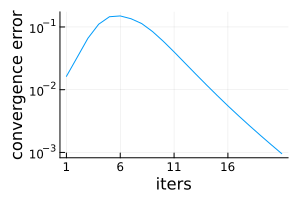

In [236]:
svd_trunc = TruncBondThresh(10, 1e-10)
iters, cb_inf = iterate!(bp_inf, maxiter=50; svd_trunc, cb=cb_inf, tol=1e-3, damp=0.2)
using Plots
plot(cb_inf.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [242]:
# svd_trunc = TruncBondThresh(30, 1e-16)
# iters, cb_inf = iterate!(bp_inf, maxiter=50; svd_trunc, cb=cb_inf, tol=1e-3, damp=0.2);

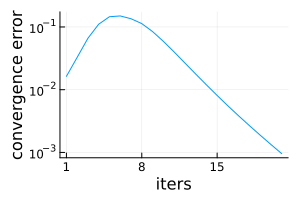

In [243]:
using Plots
plot(cb_inf.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb_inf.Δs)÷3):length(cb.Δs))

In [244]:
m_bp_inf = means(spin, bp_inf)
only(m_bp_inf)[T÷2], (1 - sinh(2βJ)^(-4))^(1/8)
# only(m_bp_inf)[T÷2], sinh(βh)/sqrt(sinh(βh)^2+exp(-4βJ))

(0.911021919224604, 0.911319377877496)

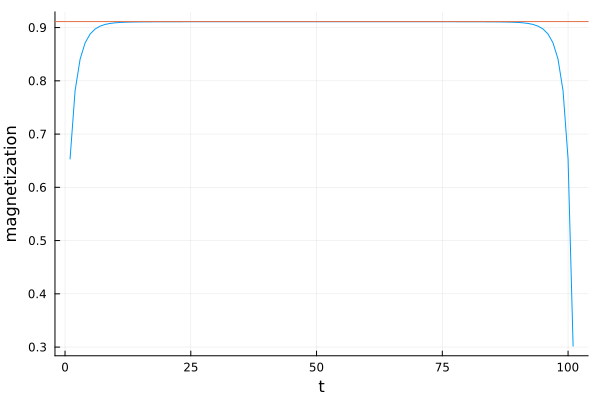

In [245]:
plot(only(m_bp_inf), label="", xlabel="t", ylabel="magnetization")
hline!([(1 - sinh(2βJ)^(-4))^(1/8)], label="")

In [246]:
F_inf = bethe_free_energy(bp_inf) / (T+1)

-1.0207937692950837